# Data processing for bump hunt

Main differences for bump hunt:
- No fully supervised set
- test set covers the whole SR / SB range



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *
from helpers.physics_functions import *
from helpers.data_transforms import *

plt.style.use("../science.mplstyle")


In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [3]:
project_id = "BSM"
scaler_id = "BSM_09_13"

working_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD"
path_to_compiled_data = f"{working_dir}/compiled_data/{project_id}"

    
codes_list  = ["BSM_XYY_jet", "BSM_HAA_jet", "SM_SIM_jet"]#["DATA_nojet"]

sim_id = "SM_SIM_jet"
signal_id = "BSM_HAA_jet"

    
uncut_data, uncut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_samesign[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data[code][key] = tmp_dict[key]
        
    
    print(code, "opp sign",  uncut_data[code][list(uncut_data[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_samesign[code][list(uncut_data[code].keys())[0]].shape)

BSM_XYY_jet opp sign (9509,)
BSM_XYY_jet same sign (6507,)
BSM_HAA_jet opp sign (353837,)
BSM_HAA_jet same sign (13501,)
SM_SIM_jet opp sign (7373313,)
SM_SIM_jet same sign (26071,)


## Visualize the data

In [4]:
feature_set = list(uncut_data[codes_list[0]].keys())
print(feature_set)

#hist_all_features(codes_list, uncut_data, feature_set, kwargs_dict_dtype, nice_labels=True)
    


['mu0_iso03', 'mu1_iso03', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'hardest_jet_btag', 'hardest_jet_pt', 'hardest_jet_eta', 'hardest_jet_phi', 'hardest_jet_mass', 'mumu_deltaR', 'mumu_deltapT', 'dimujet_deltaR']


## Make cuts

Now let's define cuts on the data. 

In [5]:

SB_left = 20
IB_left = 33
SR_left = 35
SR_right = 45
IB_right = 47
SB_right = 60


band_bounds = {"SBL": [SB_left,IB_left],
                   "IBL": [IB_left,SR_left],
                   "SR": [SR_left,SR_right],
                   "IBH": [SR_right,IB_right],
                  "SBH": [IB_right,SB_right],
                           }



plot_bins_SR = np.linspace(SR_left, SR_right, 6)
width = plot_bins_SR[1] - plot_bins_SR[0]


In [6]:
cut_data, cut_data_samesign = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    
    # these cuts do nothing
    pass_indices = (uncut_data[code]["mu0_iso04"] > -.5) & (uncut_data[code]["mu1_iso04"] > -.5)
    pass_indices_samesign = (uncut_data_samesign[code]["mu0_iso04"] > -.5) & (uncut_data_samesign[code]["mu1_iso04"] > -.5)

    
    # apply cuts to oppsign
    for feat in feature_set:
        cut_data[code][feat] = uncut_data[code][feat][pass_indices]
    # apply cuts to samesign
    for feat in feature_set:
        cut_data_samesign[code][feat] = uncut_data_samesign[code][feat][pass_indices_samesign]
    
    print(f"{code} oppsign has shape {cut_data[code][feat].shape} after cuts")
    print(f"{code} samesign has shape {cut_data_samesign[code][feat].shape} after cuts")
    

BSM_XYY_jet oppsign has shape (9509,) after cuts
BSM_XYY_jet samesign has shape (6507,) after cuts
BSM_HAA_jet oppsign has shape (353837,) after cuts
BSM_HAA_jet samesign has shape (13501,) after cuts
SM_SIM_jet oppsign has shape (7373313,) after cuts
SM_SIM_jet samesign has shape (26071,) after cuts


Check how local cuts affect the starting significance

BSM_XYY_jet (6,)
BSM_HAA_jet (348948,)
SM_SIM_jet (965258,)


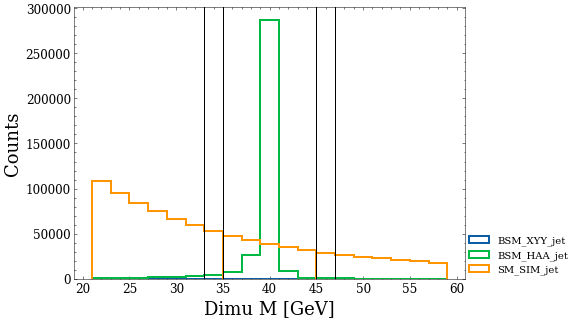

In [7]:
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, True)
x = np.linspace(SB_left, SB_right, 100) # plot curve fit

plt.figure(figsize = (7,5))

for code in codes_list:
    
    masses_with_bounds = cut_data[code]["dimu_mass"][(cut_data[code]["dimu_mass"] >= SB_left) & (cut_data[code]["dimu_mass"] <= SB_right)]
    print(code, masses_with_bounds.shape)
    plt.hist(masses_with_bounds, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = code)


plt.axvline(SR_left, color = "k")
plt.axvline(SR_right, color = "k")

plt.axvline(IB_left, color = "k")
plt.axvline(IB_right, color = "k")

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))


plt.show()
 
    

BSM_XYY_jet (6,)
BSM_HAA_jet (9736,)
SM_SIM_jet (15166,)


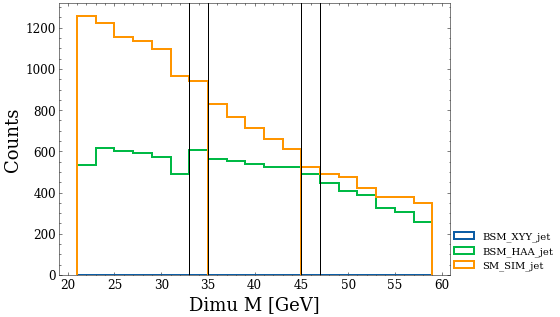

In [8]:


plt.figure(figsize = (7,5))

for code in codes_list:
    
    masses_with_bounds_samesign = cut_data_samesign[code]["dimu_mass"][(cut_data_samesign[code]["dimu_mass"] >= SB_left) & (cut_data_samesign[code]["dimu_mass"] <= SB_right)]
    print(code, masses_with_bounds_samesign.shape)
    plt.hist(masses_with_bounds_samesign, bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = code)



plt.axvline(SR_left, color = "k")
plt.axvline(SR_right, color = "k")

plt.axvline(IB_left, color = "k")
plt.axvline(IB_right, color = "k")

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))


plt.show()
 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)


Split data into bands

In [9]:
bands = ["SBL", "IBL", "SR", "IBH", "SBH"]


preproc_dicts, preproc_dicts_samesign = {b:{} for b in bands}, {b:{} for b in bands}


for code in codes_list:
    for b in bands:
        
        # opp sign
        loc_pass_indices = (cut_data[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts[b][code] = {}
        for feat in feature_set:
            preproc_dicts[b][code][feat] = cut_data[code][feat][loc_pass_indices]
            
       
        
        # same sign
        loc_pass_indices_samesign = (cut_data_samesign[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_samesign[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts_samesign[b][code] = {}
        for feat in feature_set:
            preproc_dicts_samesign[b][code][feat] = cut_data_samesign[code][feat][loc_pass_indices_samesign]
  
    print()
    

# Inject signal

In [10]:
N_bkg_SR_total = preproc_dicts["SR"][sim_id]["dimu_mass"].shape[0]
N_sig_SR_total = preproc_dicts["SR"][signal_id]["dimu_mass"].shape[0]

print(f"{N_bkg_SR_total} bkg in SR, {N_sig_SR_total} sig in SR")


196270 bkg in SR, 329689 sig in SR


In [11]:
# set aside some events for the fully supervised case (train and test)
N_bkg_SR_fullsup, N_sig_SR_fullsup = 6000, 6000

# specify the fraction of events in each band that we set aside
frac_bkg_fullsup = N_bkg_SR_fullsup/N_bkg_SR_total
frac_sig_fullsup = N_sig_SR_fullsup/N_sig_SR_total


N_bkg_SR_bump_hunt = N_bkg_SR_total - N_bkg_SR_fullsup
N_sig_SR_bump_hunt = N_sig_SR_total - N_sig_SR_fullsup


print(f"{frac_bkg_fullsup} bkg, {frac_sig_fullsup} sig fraction set aside for full sup")
print(f"{N_bkg_SR_bump_hunt} bkg, {N_sig_SR_bump_hunt} sig events for bump hunt")
print()


# calculate how many signal events to inject into the SR
desired_significance = 10
# only the bump hunt sample counts
N_sig_inject_SR = int(np.sqrt(N_bkg_SR_bump_hunt)*desired_significance)

frac_sig_to_inject = N_sig_inject_SR/N_sig_SR_total
print(f"frac sig to inject: {frac_sig_to_inject}")

print(f"Attempting to inject {N_sig_inject_SR} events into the SR.")



0.030570132980078463 bkg, 0.018198969331703514 sig fraction set aside for full sup
190270 bkg, 323689 sig events for bump hunt

frac sig to inject: 0.01322761754259317
Attempting to inject 4361 events into the SR.


In [12]:
# do the injection



preproc_dicts_fullsup_bkg, preproc_dicts_fullsup_sig, preproc_dicts_bump_hunt = {b:{} for b in bands},  {b:{} for b in bands}, {b:{} for b in bands}

sig_indices_to_inject = {}

for b in bands:
    
    print(b)
    
    for feat in feature_set:
    
        # take the first few events for the test set
        # TODO: we only need the SR events for the test set. Ideally the SB could be used for flow training. But this makes for a less clean story with the bump hunt
        N_bkg_fullsup = int(frac_bkg_fullsup*preproc_dicts[b][sim_id][feat].shape[0])
        preproc_dicts_fullsup_bkg[b][feat] = preproc_dicts[b][sim_id][feat][:N_bkg_fullsup]
        
        N_sig_fullsup = int(frac_sig_fullsup*preproc_dicts[b][signal_id][feat].shape[0])
        preproc_dicts_fullsup_sig[b][feat] = preproc_dicts[b][signal_id][feat][:N_sig_fullsup]
        
        if feat == "dimu_mass":
            print(f"Fullsup dataset has {N_bkg_fullsup} bkg, {N_sig_fullsup} signal")
            
        # choose signal to inject into the band
        try:
            band_indices = sig_indices_to_inject[b]
        except:
            N_sig_inject_band = int(frac_sig_to_inject*preproc_dicts[b][signal_id][feat].shape[0])
            print(f"Injecting {N_sig_inject_band} events into band")
            band_indices = np.random.choice(range(N_sig_fullsup, preproc_dicts[b][signal_id]["dimu_mass"].shape[0]), size=N_sig_inject_band, replace=False)
            sig_indices_to_inject[b] = band_indices
        
        
        preproc_dicts_bump_hunt[b][feat] = np.hstack((preproc_dicts[b][sim_id][feat], preproc_dicts[b][signal_id][feat][band_indices]))
        
    print()
      


SBL
Injecting 157 events into band
Fullsup dataset has 16750 bkg, 216 signal

IBL
Injecting 59 events into band
Fullsup dataset has 1626 bkg, 81 signal

SR
Injecting 4361 events into band
Fullsup dataset has 6000 bkg, 6000 signal

IBH
Injecting 6 events into band
Fullsup dataset has 891 bkg, 9 signal

SBH
Injecting 30 events into band
Fullsup dataset has 4239 bkg, 42 signal



5575.510657621955 195055.48934237804



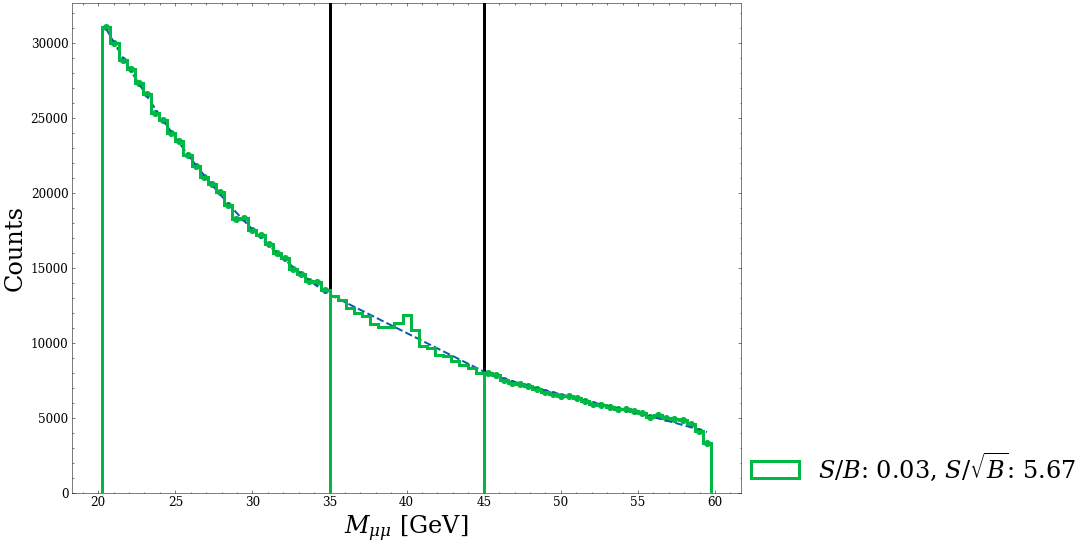

In [13]:
# check the starting significance

remove_edge = True

x = np.linspace(SB_left, SB_right, 100)

# get bins, bin centers
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, remove_edge, 20)

fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic":nfit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio


trial_test_set = np.hstack([preproc_dicts_bump_hunt["SBL"]["dimu_mass"], preproc_dicts_bump_hunt["IBL"]["dimu_mass"], preproc_dicts_bump_hunt["SR"]["dimu_mass"], preproc_dicts_bump_hunt["IBH"]["dimu_mass"], preproc_dicts_bump_hunt["SBH"]["dimu_mass"]])

plt.figure(figsize = (12, 9))


# get the fit function to SB background
popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(trial_test_set, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all, SBL_rescale=None, SBH_rescale=None)
#print("chi2/dof:", chi2/n_dof)
# plot the fit function
plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed")    

# calculate significance of bump
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(trial_test_set, fit_function, plot_bins_SR, SR_left, SR_right, popt)
print(num_S_expected_in_SR, num_B_expected_in_SR)

y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
B_error = np.sum(y_err)

label_string = "$S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

plt.hist(trial_test_set, bins = plot_bins_all, lw = 3, histtype = "step",label = label_string)
plt.scatter(plot_centers_SB, y_vals)
    
    

print() 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.show()
    

## Preprocessing

Standard scaling is fine

In [17]:
from sklearn.preprocessing import StandardScaler

sizes_dict = {}


proccessed_data_dict, proccessed_data_dict_samesign  = {b:{"s_inj_data":{}} for b in bands}, {b:{"s_inj_data":{}} for b in bands}
proccessed_data_dict_test_bkg, proccessed_data_dict_test_sig  = {b:{"s_inj_data":{}} for b in bands}, {b:{"s_inj_data":{}} for b in bands}




for feat in feature_set: 
    
    # train the preprocessor on the opp sign data only
    data_SB = np.hstack((preproc_dicts_bump_hunt["SBL"][feat], preproc_dicts_bump_hunt["SBH"][feat])).reshape(-1, 1)
    
    if feat == "dimu_mass": # don't logit transform
        mass_scaler = StandardScaler()
        mass_scaler = mass_scaler.fit(data_SB)
        
        with open(f"{working_dir}/projects/{scaler_id}/processed_data/mass_scaler_BSM", "wb") as ofile:
            pickle.dump(mass_scaler, ofile)
            
        for b in bands:
            proccessed_data_dict[b]["s_inj_data"][feat] = mass_scaler.transform(preproc_dicts_bump_hunt[b][feat].reshape(-1,1))
            proccessed_data_dict_samesign[b]["s_inj_data"][feat] =  mass_scaler.transform(preproc_dicts_samesign[b][sim_id][feat].reshape(-1,1))
            proccessed_data_dict_test_bkg[b]["s_inj_data"][feat] =  mass_scaler.transform(preproc_dicts_fullsup_bkg[b][feat].reshape(-1,1))
            proccessed_data_dict_test_sig[b]["s_inj_data"][feat] =  mass_scaler.transform(preproc_dicts_fullsup_sig[b][feat].reshape(-1,1))

            sizes_dict[b] = proccessed_data_dict[b]["s_inj_data"][feat].shape[0]
    
    else: 
        
        data_all = np.hstack((preproc_dicts_bump_hunt["SBL"][feat], preproc_dicts_bump_hunt["SBH"][feat], preproc_dicts_bump_hunt["SR"][feat])).reshape(-1, 1)
        all_min = np.min(data_all)
        all_max = np.max(data_all)
        # logit transform the features
    
        transformed_feats = logit_transform(data_SB, all_min, all_max)
        # subtract off mean, std of the training set
        mean_to_sub = np.mean(transformed_feats)
        std_to_sub = np.std(transformed_feats)

    
        for b in bands:
            proccessed_data_dict[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_bump_hunt[b][feat], all_min, all_max) - mean_to_sub)/std_to_sub
            proccessed_data_dict_samesign[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_samesign[b][sim_id][feat], all_min, all_max) - mean_to_sub)/std_to_sub
            proccessed_data_dict_test_bkg[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_fullsup_bkg[b][feat], all_min, all_max) - mean_to_sub)/std_to_sub
            proccessed_data_dict_test_sig[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_fullsup_sig[b][feat], all_min, all_max) - mean_to_sub)/std_to_sub

            #print(np.max(proccessed_data_dict[b]["s_inj_data"][feat]), np.min(proccessed_data_dict[b]["s_inj_data"][feat]))

 

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:8: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1-x_norm+1e-10)+1e-10)


In [18]:
print(sizes_dict)

{'SBL': 548097, 'IBL': 53258, 'SR': 200631, 'IBH': 29174, 'SBH': 138711}


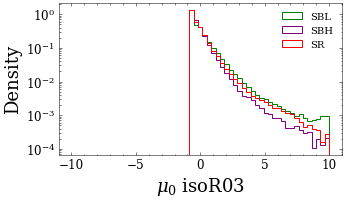

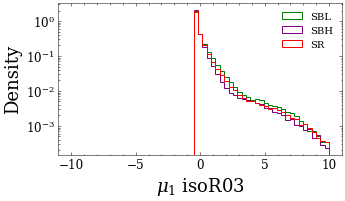

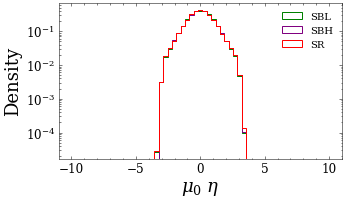

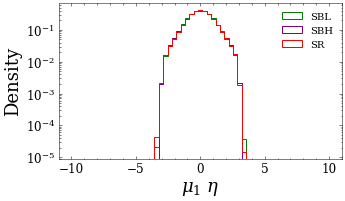

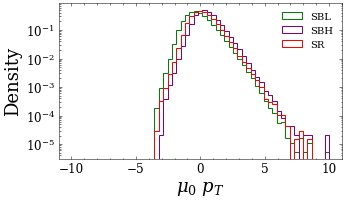

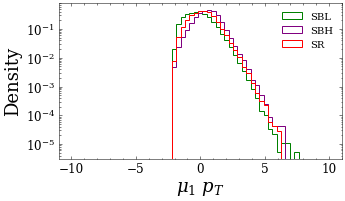

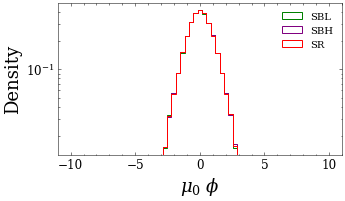

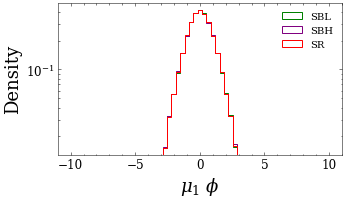

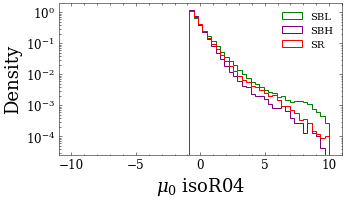

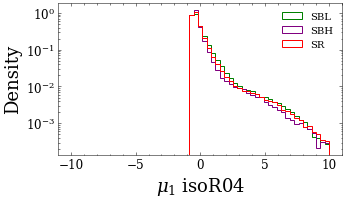

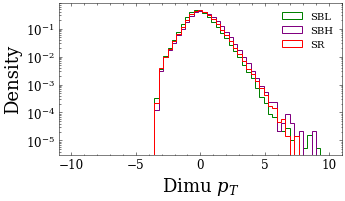

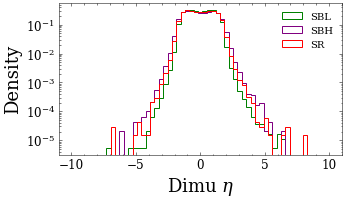

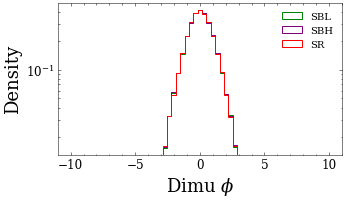

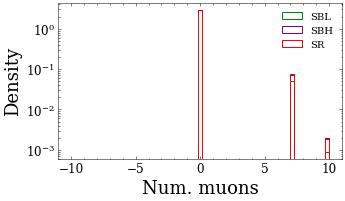

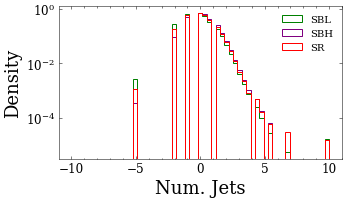

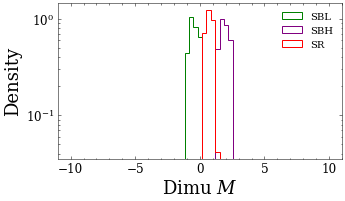

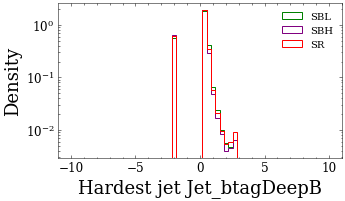

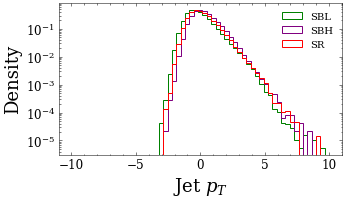

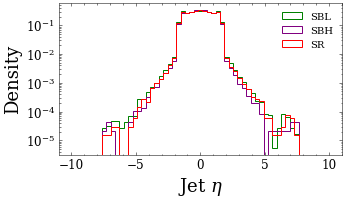

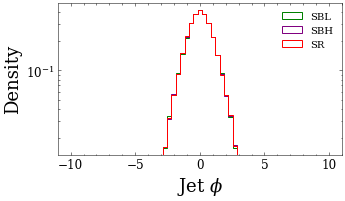

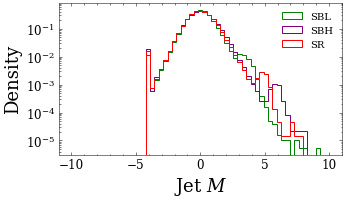

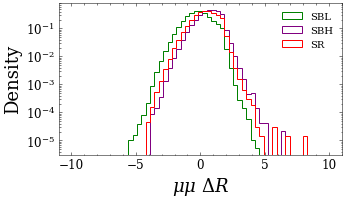

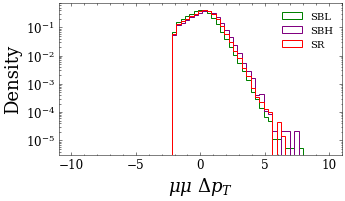

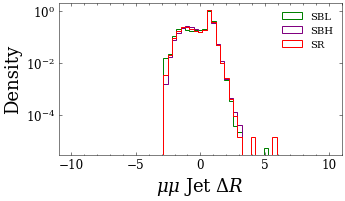

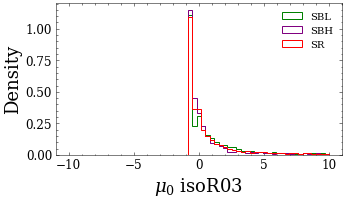

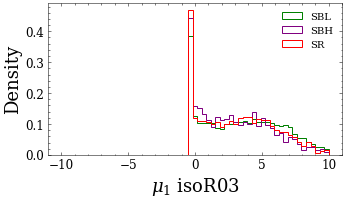

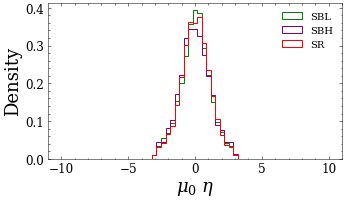

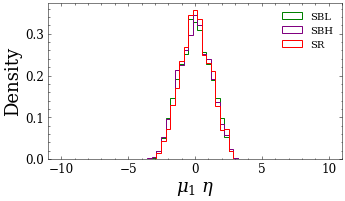

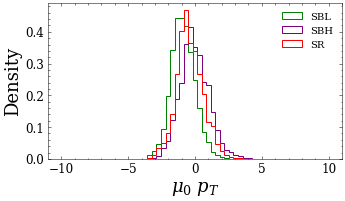

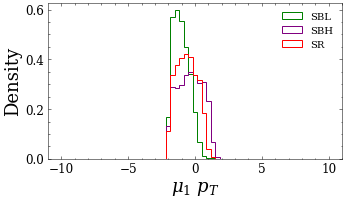

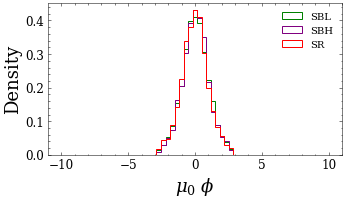

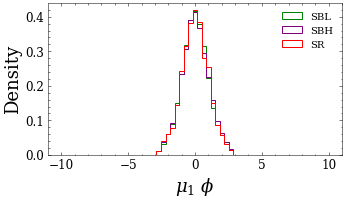

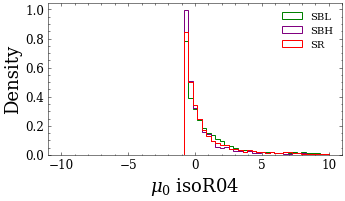

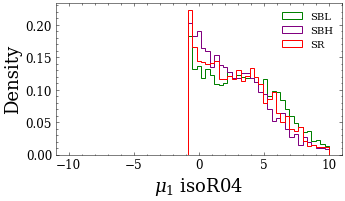

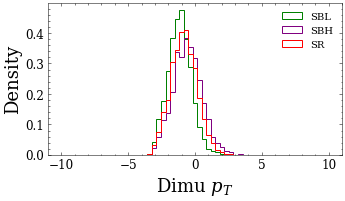

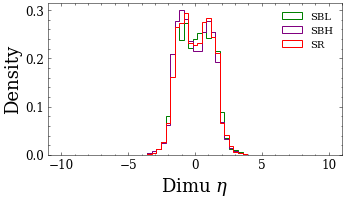

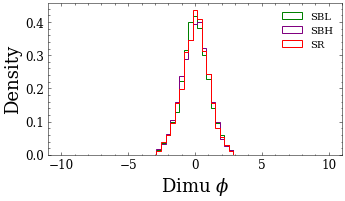

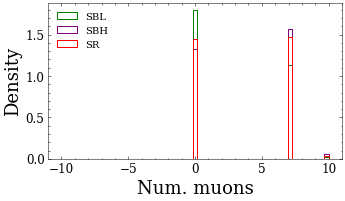

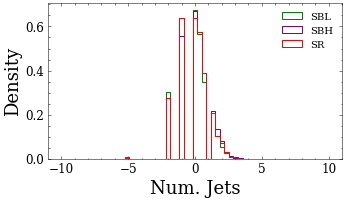

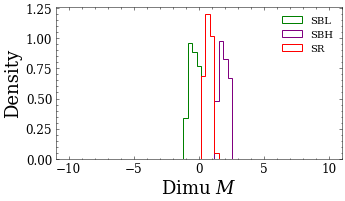

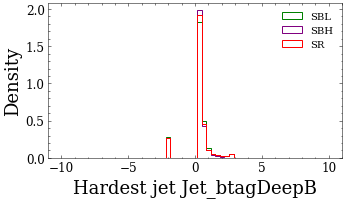

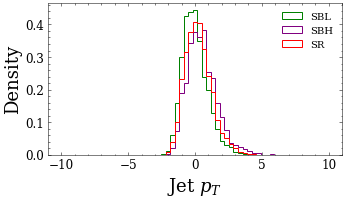

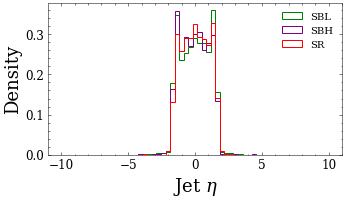

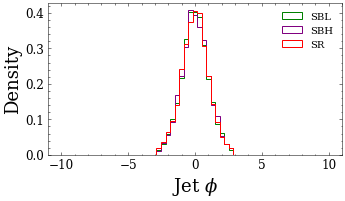

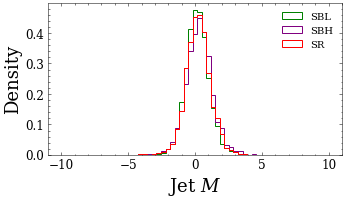

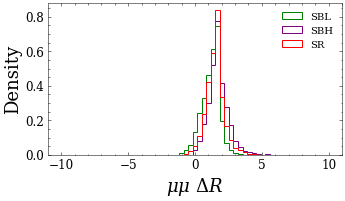

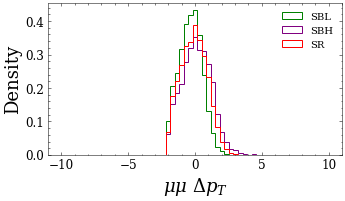

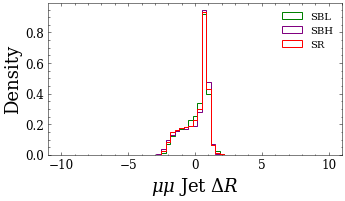

In [19]:
hist_all_features_dict([proccessed_data_dict["SBL"]["s_inj_data"], proccessed_data_dict["SBH"]["s_inj_data"], proccessed_data_dict["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=True, nice_labels=True)


hist_all_features_dict([proccessed_data_dict_samesign["SBL"]["s_inj_data"], proccessed_data_dict_samesign["SBH"]["s_inj_data"], proccessed_data_dict_samesign["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=False, nice_labels=True)






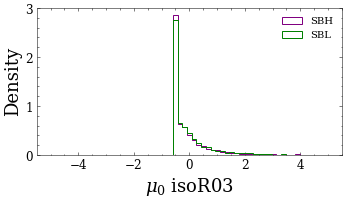

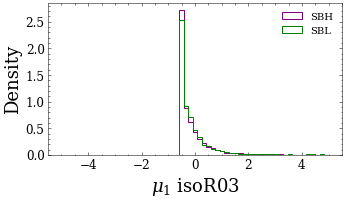

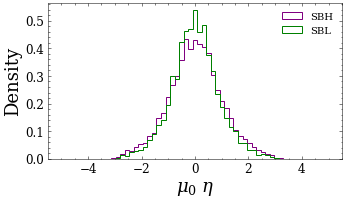

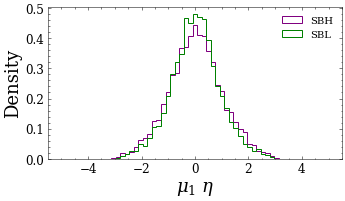

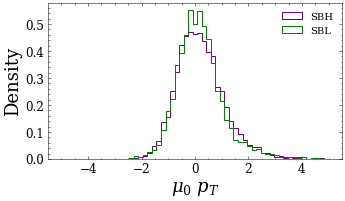

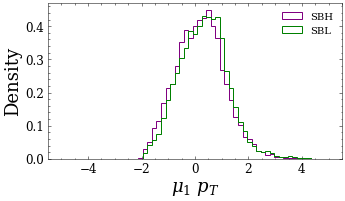

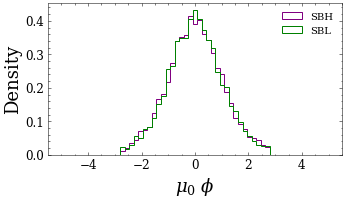

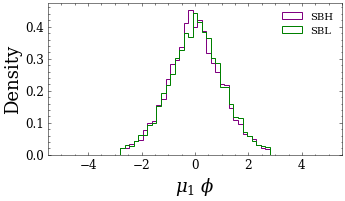

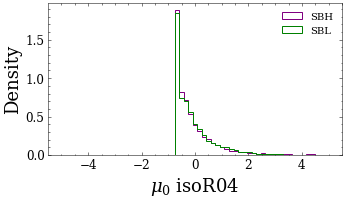

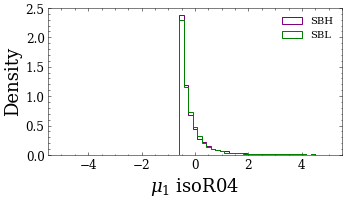

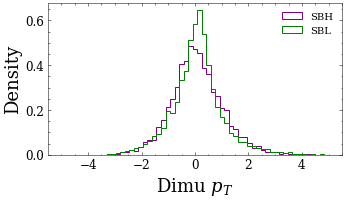

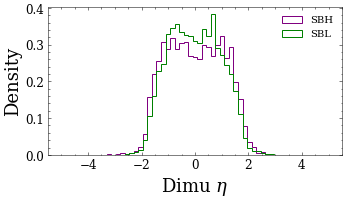

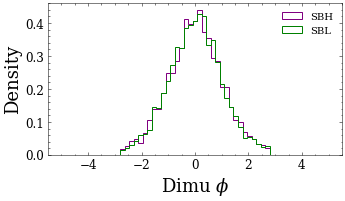

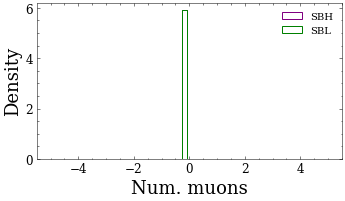

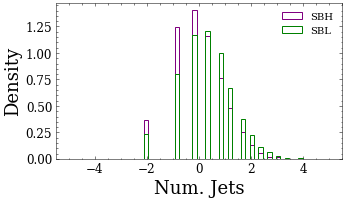

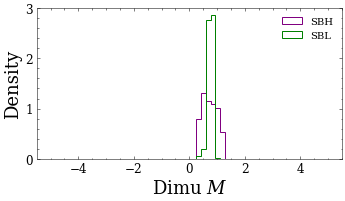

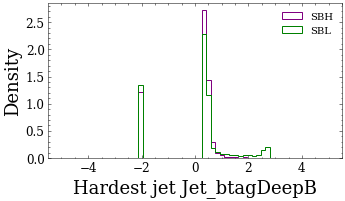

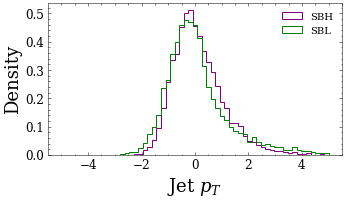

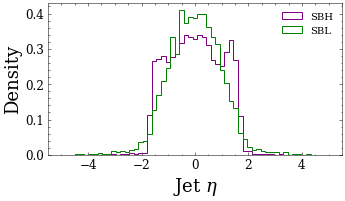

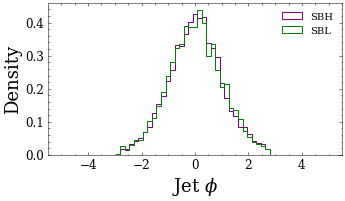

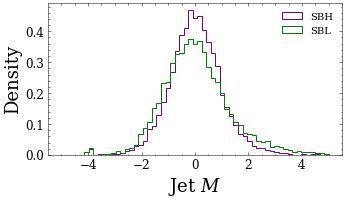

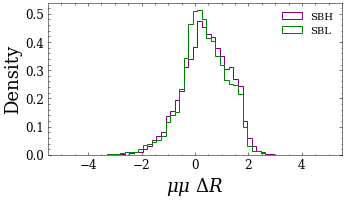

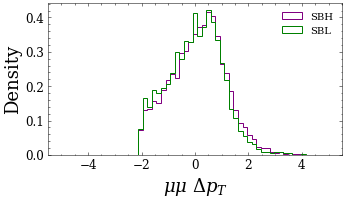

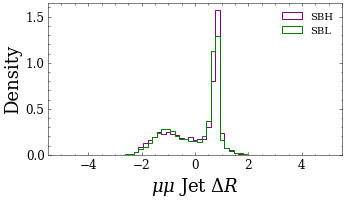

In [20]:
hist_all_features_dict([proccessed_data_dict_test_bkg["SR"]["s_inj_data"], proccessed_data_dict_test_sig["SR"]["s_inj_data"]], 
                       ["SBH", "SBL"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=5, image_path=None, yscale_log=False, nice_labels=True)



In [21]:
with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_jet_train_band_data", "wb") as ofile:
    pickle.dump(proccessed_data_dict, ofile)
        
        
with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_jet_test_bkg_band_data", "wb") as ofile:
    pickle.dump(proccessed_data_dict_test_bkg, ofile)
    
with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_jet_test_sig_band_data", "wb") as ofile:
    pickle.dump(proccessed_data_dict_test_sig, ofile)
    
    
with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_jet_samesign_band_data", "wb") as ofile:
    pickle.dump(proccessed_data_dict_samesign, ofile)
